In [1]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sys.path.insert(0, './analysis/scripts/')
from tb_colormaps import * 

plt.style.use('bursa.mplstyle')

######################## PATH CONFIG ################################

df_loc = '../../data/vdj/integrated_cell_calls.tsv.gz'
FIGURE_OUTDIR = '../../analysis/figures/si figures/'

In [2]:


######################## ############ ################################

df = pd.read_table(df_loc, usecols=['sample_uid_gex',
                                    'sample_type',
                                    'tissue',
                                    'n_umis',
                                    'n_reads',
                                    'vdj_sequence',
                                    'Immune_All_Low_predicted_labels',
                                    'probable_hq_single_b_cell',
                                    'probable_hq_single_not_b_cell',
                                    'multiplet_status',
                                    'c_call',
                                    'v_mismatch'])


################################################################################################################

df['has_vdj'] = df.vdj_sequence.notna()

s = {"IGHM":"IGHM|D", "IGHD":"IGHM|D"}
df['switched'] = df.c_call.map(lambda x: s.get(x, 'switched'))
df['switched'] = df['switched'] == 'switched'
df['hypermutated'] = df.v_mismatch.map(lambda x: True if x > 0 else False)
# focus on GEX samples
df = df[df.sample_uid_gex.notna()]



/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_10837/4250297115.py:3: DtypeWarning: Columns (4,5,77,121,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(df_loc, usecols=['sample_uid_gex',


In [3]:
# calculate ambient rates based on vdj presence in non-B cells
ambient_rate = df[(df.probable_hq_single_not_b_cell == True)].groupby(['sample_uid_gex'])['has_vdj'].mean()
num_hq_not_bcells = df[(df.probable_hq_single_not_b_cell == True)].groupby(['sample_uid_gex']).size()
ambient_rate = ambient_rate[num_hq_not_bcells > 50]
ambient_rate = ambient_rate.to_dict()

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_10837/3361393772.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcells.loc[:,'subtype'] = bcells.Immune_All_Low_predicted_labels.map(lambda x: subtype_dict.get(x,x))


Memory B cells          152573
Naive B cells           145658
ASCs                     21726
ABCs                      7083
GC B cells                 173
Pre-pro-B cells             14
Transitional B cells         9
Cycling B cells              3
Pro-B cells                  3
B cells                      1
Small pre-B cells            1
Name: subtype, dtype: int64


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_10837/3361393772.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Index(['sample_uid_gex', 'subtype', 'has_vdj', 'subset_size', 'ambient_rate',
       'p_real_vdj', 'p_ambient_vdj'],
      dtype='object')
Empty DataFrame
Columns: [sample_uid_gex, measured, subtype, has_vdj, subset_size, ambient_rate, p_real_vdj, p_ambient_vdj, baseline switched, Ambient-based estimate, Naive-population-based estimate]
Index: []
Empty DataFrame
Columns: [sample_uid_gex, measured, subtype, has_vdj, subset_size, ambient_rate, p_real_vdj, p_ambient_vdj, baseline hypermutated, Ambient-based estimate, Naive-population-based estimate]
Index: []
Index(['sample_uid_gex', 'subtype', 'has_vdj', 'subset_size', 'ambient_rate',
       'p_real_vdj', 'p_ambient_vdj'],
      dtype='object')


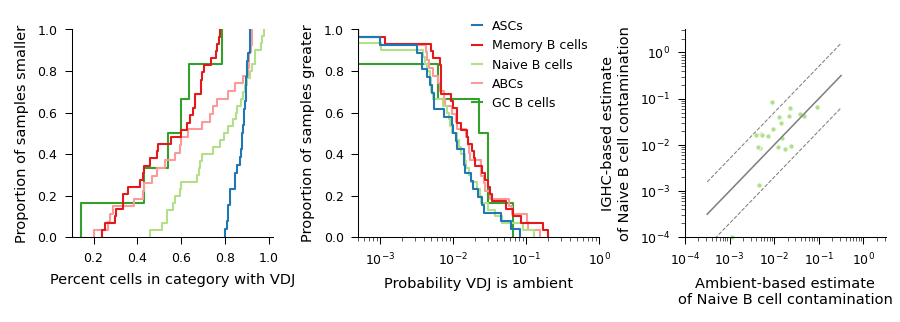

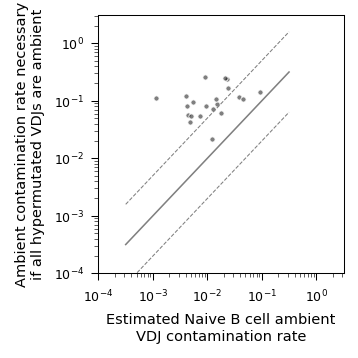

In [4]:

########### HQ B cells only ###############

bcells = df[(df.probable_hq_single_b_cell==True)]
subtype_dict = {'Plasma cells':'ASCs',
                'Plasmablasts':'ASCs',
                'Age-associated B cells':'ABCs',
                'Germinal center B cells':"GC B cells",
                'Proliferative germinal center B cells':'GC B cells'}
df['subtype'] = ''
bcells.loc[:,'subtype'] = bcells.Immune_All_Low_predicted_labels.map(lambda x: subtype_dict.get(x,x))

common_celltypes = bcells['subtype'].value_counts()
print(common_celltypes)
common_celltypes = common_celltypes[common_celltypes > 99].index.values

bcells_common = bcells[bcells.subtype.isin(common_celltypes)]
bcells_rare = bcells[~bcells.subtype.isin(common_celltypes).astype(bool)]

for subset, label in [(bcells_common, 'common-singlets')]:
    vdj_rates = subset.groupby(['sample_uid_gex', 'subtype'])['has_vdj'].mean().reset_index()

    # estimate ambient rates only for subtypes represented by at least 10 cells in a sample
    subset_sizes = subset.groupby(['sample_uid_gex','subtype']).size()
    vdj_rates['subset_size'] = vdj_rates.apply(lambda x : subset_sizes[(x.sample_uid_gex, x.subtype)], axis=1)
    vdj_rates = vdj_rates[vdj_rates['subset_size'] > 9]
    
    #further exclude samples if we do not have an estimate of the ambient rate
    have_ambient_estimate = vdj_rates.sample_uid_gex.isin(ambient_rate.keys())
    vdj_rates = vdj_rates[have_ambient_estimate]


    ########### B cells odds ratio ###############

    vdj_rates['ambient_rate'] = vdj_rates.sample_uid_gex.map(ambient_rate)
    vdj_rates['p_real_vdj'] = 1 - vdj_rates['ambient_rate']/vdj_rates['has_vdj']
    vdj_rates['p_ambient_vdj'] = vdj_rates['ambient_rate']/vdj_rates['has_vdj'] + 0.5*10**-3


    fig = plt.figure(figsize=(7,1.8))
    fig_naive_hm_excess, ax_naive_hm_excess = plt.subplots(figsize=(2.4,2.4))

    gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios = [1,1.2,1], wspace=0.4)

    ax_p_any = fig.add_subplot(gs[0])
    ax_p_correct = fig.add_subplot(gs[1], sharey=ax_p_any)
    ax_naive = fig.add_subplot(gs[2])
    g= sns.ecdfplot(data=vdj_rates, 
                    x ='has_vdj', 
                    ax=ax_p_any,
                    hue='subtype',
                    palette=bcelltype_colors_alt,
                    legend=False)

    ax_p_any.set_xlabel("Percent cells in category with VDJ")
    ax_p_any.set_ylabel("Proportion of samples smaller")


    g= sns.ecdfplot(data=vdj_rates, 
                    x ='p_ambient_vdj', 
                    ax = ax_p_correct,
                    hue='subtype',
                    palette=bcelltype_colors_alt, 
                    complementary=True,
                    legend=True)
    ax_p_correct.set_xlim([0.5*10**-3,1.0])
    ax_p_correct.set_xscale('log')
    ax_p_correct.set_xlabel("Probability VDJ is ambient")
    ax_p_correct.set_ylabel("Proportion of samples greater")
    sns.move_legend(g, frameon=False, loc='upper right', bbox_to_anchor=(1.,1.1), title='', handlelength=0.8)

    fig.tight_layout()
    sns.despine(fig)



    ## Naive ambient estimation

    print(vdj_rates.columns)
    IGHC_label = f'IGHC-based estimate\nof Naive B cell contamination'
    HM_label = f'Ambient contamination rate necessary\nif all hypermutated VDJs are ambient'
    for count, marker, axes, color, label in [('switched',
                                        '.',
                                        ax_naive,
                                        bcelltype_colors_alt['Naive B cells'], 
                                        IGHC_label),
                                        ('hypermutated',
                                        '.',
                                        ax_naive_hm_excess,
                                        (0,0,0,0.5),
                                        HM_label)]:

        data = bcells[(bcells.subtype == "Naive B cells") & (bcells.has_vdj)].groupby("sample_uid_gex")[count].mean()
        data.name = 'measured'
        ambient_baseline = df[(df.probable_hq_single_not_b_cell==True) & (df.has_vdj)& (df.multiplet_status < 2)].groupby("sample_uid_gex")[count].mean()

        ambient_baseline.name=f'baseline {count}'
        data = pd.merge(data, vdj_rates, 
                        left_on='sample_uid_gex',
                        right_on='sample_uid_gex')
        data = pd.merge(data, ambient_baseline, on='sample_uid_gex')

        
        data = data[data.subtype == 'Naive B cells']
        data['subset_size'] = vdj_rates.apply(lambda x : subset_sizes[(x.sample_uid_gex, 'Naive B cells')], axis=1)
        data = data[data.subset_size > 9]
        data['Ambient-based estimate'] = data.p_ambient_vdj + 10**-4
        data[f'Naive-population-based estimate'] = (data['measured'])/(data[f'baseline {count}']) + 10**-4
        print(data[data['Ambient-based estimate'] > 1])
        # axes.set_title('Naive B cell contamination rate')
        sns.scatterplot(data,
                        x='Ambient-based estimate', 
                        y=f'Naive-population-based estimate', 
                        color=color, 
                        legend=False, 
                        ax=axes, 
                        marker=marker,
                        clip_on=False)
        axes.set_xlabel('Ambient-based estimate\nof Naive B cell contamination')
        axes.set_ylabel(label)

        axes.set_xscale('log')
        axes.set_yscale('log')
        axes.set
        xs = np.logspace(-3.5,-0.5,20,base=10)
        ys_lower=0.2*xs
        ys_upper = 5*xs
        axes.plot(xs,ys_lower,  '--', color='0.5', lw=0.5)
        axes.plot(xs,ys_upper, '--', color='0.5', lw=0.5)
        axes.plot(xs,xs, color='0.5', lw=0.75)
        axes.set_xlim([10**-4,10**0.5])
        axes.set_ylim([10**-4,10**0.5])
        fig.savefig(f'{FIGURE_OUTDIR}/bcell_VDJs_common-singlets.pdf', bbox_inches='tight')

    ax_naive_hm_excess.set_xlabel('Estimated Naive B cell ambient\nVDJ contamination rate')
    fig_naive_hm_excess.tight_layout()
    fig_naive_hm_excess.savefig(f'{FIGURE_OUTDIR}/naive_hm_vs_ambient_rate.pdf', bbox_inches='tight')
    print(vdj_rates.columns)
    vdj_rates.to_csv(f'../../data/vdj/ambient_rate_and_prob_own_vdj_by_celltype_{label}.tsv',
                     index=True,
                     sep='\t')


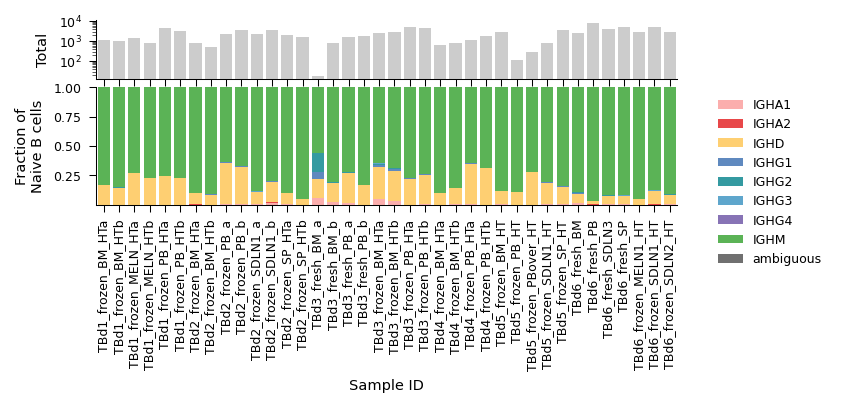

In [5]:
naive_b_cells = (df.probable_hq_single_b_cell == True) \
                & (df.multiplet_status < 2) \
                & (df.Immune_All_Low_predicted_labels == "Naive B cells") \
                & (df.has_vdj == True)
naive_c_call_distribution = df[naive_b_cells].groupby(['sample_uid_gex'])['c_call'].value_counts(normalize=True).unstack().fillna(0)
naive_b_cell_counts = df[naive_b_cells].groupby(['sample_uid_gex'])['c_call'].count()
naive_b_cell_counts = naive_b_cell_counts.reindex(naive_c_call_distribution.index).fillna(0)


fig = plt.figure(figsize=(5,1.6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2],figure=fig, hspace=0.1)
ax = [plt.subplot(gs[0]), plt.subplot(gs[1])]

xs = np.arange(len(naive_c_call_distribution.index))
lower_naive = np.zeros(len(xs))
ax[1].set_ylabel('Fraction of\nNaive B cells', fontsize=7)
ax[1].set_xlabel('Sample ID', fontsize=7)
ax[0].set_ylabel('Total', fontsize=7)
IGH_colors.update({'ambiguous':'0.3'})
for c_call in naive_c_call_distribution.columns:
    if c_call == 'sample_uid_gex' or c_call == 'IGLC1':
        continue
    ax[1].bar(xs, naive_c_call_distribution[c_call], bottom=lower_naive, label=c_call, color=IGH_colors[c_call], alpha=0.8)
    lower_naive += naive_c_call_distribution[c_call]

ax[0].bar(xs, naive_b_cell_counts, label='Naive B cells', color = 'k', alpha=0.2)
sns.despine(fig)
ax[0].set_xticks(xs, [])
ax[1].set_xticks(xs, naive_c_call_distribution.index, rotation=90);
for i in range(2):
    ax[i].set_xlim([-0.5, len(xs)-0.5])
ax[1].set_ylim([1e-4, 1])
ax[0].set_yscale('log')
# ax[1].set_yscale('log')
ax[1].legend(bbox_to_anchor=(1.05,1), frameon=False)


fig.savefig(f'{FIGURE_OUTDIR}/naive_isotype_usage.pdf', bbox_inches='tight')